<a href="https://colab.research.google.com/github/Phenwathe-alt/Digital-Portfolio/blob/main/Copy_of_Irradiance_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler


In [ ]:
import pandas as pd

# Load Data
data = pd.read_csv('solcast_dataset.csv')  # Replace with your dataset file

In [ ]:
print("First 5 rows of the dataset:")
print(data.head())

# Display summary statistics
print("\nSummary Statistics:")
print(data.describe())

First 5 rows of the dataset:
   air_temp  albedo  azimuth  clearsky_dhi  clearsky_dni  clearsky_ghi  \
0        12    0.18      -13             0             0             0   
1        12    0.15      -38             0             0             0   
2        12    0.15      -59             0             0             0   
3        12    0.15      -74             0             0             0   
4        12    0.15      -87             0             0             0   

   clearsky_gti  cloud_opacity  dewpoint_temp  dhi  ...  \
0             0           94.2           11.6    0  ...   
1             0           94.3           11.6    0  ...   
2             0           91.1           11.6    0  ...   
3             0           90.6           11.6    0  ...   
4             0           91.7           11.4    0  ...   

   snow_water_equivalent  snow_soiling_rooftop  snow_soiling_ground  \
0                    0.0                     0                    0   
1                    0.0     

In [ ]:
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

# Alternatively, display the total number of elements in the dataset
print(f"Total number of elements: {data.size}")

Number of rows: 24384
Number of columns: 28
Total number of elements: 682752


In [ ]:
import pandas as pd

# Data Preprocessing
def preprocess_data(data):
    data = data.dropna()  # Drop missing values
    data['period_end'] = pd.to_datetime(data['period_end'])
    data = data.sort_values(by='period_end')
    return data

data = preprocess_data(data)

# Convert the time column to a datetime object if present
if 'period_end' in data.columns:  # Replace 'time' with the actual name of your time column
    data['period_end'] = pd.to_datetime(data['period_end'])
    data.set_index('period_end', inplace=True)

# Identify non-numeric columns, excluding 'period_end' if it's of type datetime
non_numeric_columns = data.select_dtypes(include=['object', 'category']).columns
non_numeric_columns = [column for column in non_numeric_columns if column != 'period_end']

# Drop non-numeric columns except 'period_end'
data = data.drop(non_numeric_columns, axis=1)
print("Remaining Columns:", data.columns)

# Function to add time-based features
def add_time_features(df):
    df['hour'] = df.index.hour  # Extract hour of the day from the index (which is 'period_end')
    df['day'] = df.index.day  # Extract day of the month
    df['weekday'] = df.index.weekday  # Extract day of the week (0=Monday, 6=Sunday)
    df['month'] = df.index.month  # Extract month
    df['year'] = df.index.year  # Extract year
    return df

# Apply time feature extraction to the data
data = add_time_features(data)

# Show the first few rows to ensure the features have been added correctly
print(data.head())


Remaining Columns: Index(['air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni',
       'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi',
       'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate',
       'relative_humidity', 'surface_pressure', 'snow_depth',
       'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground',
       'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m',
       'wind_speed_10m', 'zenith'],
      dtype='object')
                           air_temp  albedo  azimuth  clearsky_dhi  \
period_end                                                           
2022-01-01 01:00:00+00:00        12    0.18      -13             0   
2022-01-01 02:00:00+00:00        12    0.15      -38             0   
2022-01-01 03:00:00+00:00        12    0.15      -59             0   
2022-01-01 04:00:00+00:00        12    0.15      -74             0   
2022-01-01 05:00:00+00:00        12    0.15      -87             0 

In [ ]:
# Feature Selection
selected_features = ['air_temp','dhi','dni','cloud_opacity','relative_humidity','albedo','surface_pressure','zenith']  # Exclude GHI if it's the target
target_variable = "gti"  # Use GTI as the target variable

X = data[selected_features]
y = data[target_variable]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split into train and test sets (80:20 split)
train_size = int(len(data) * 0.8)
train, test = data[target_variable][:train_size], data[target_variable][train_size:]



In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
selected_features = ['air_temp', 'dhi', 'dni', 'cloud_opacity', 'relative_humidity', 'albedo', 'surface_pressure', 'zenith']  # Exclude GHI if it's the target
target_variable = "gti"  # Use GTI as the target variable

# Splitting features and target
X = data[selected_features]
y = data[target_variable]

# Train-Test Split (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display sizes of training and testing sets
print(f"Training features size: {X_train.shape}")
print(f"Testing features size: {X_test.shape}")
print(f"Training target size: {y_train.shape}")
print(f"Testing target size: {y_test.shape}")

# Optional: Splitting target variable directly (manual slicing)
train_size = int(len(data) * 0.8)
train_target = data[target_variable][:train_size]
test_target = data[target_variable][train_size:]

print(f"Manual train target size: {len(train_target)}")
print(f"Manual test target size: {len(test_target)}")


Training features size: (19507, 8)
Testing features size: (4877, 8)
Training target size: (19507,)
Testing target size: (4877,)
Manual train target size: 19507
Manual test target size: 4877


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


ARIMA - MAE: 187.87017618259682, RMSE: 239.7792571055752, R2: -0.0037086227144853545


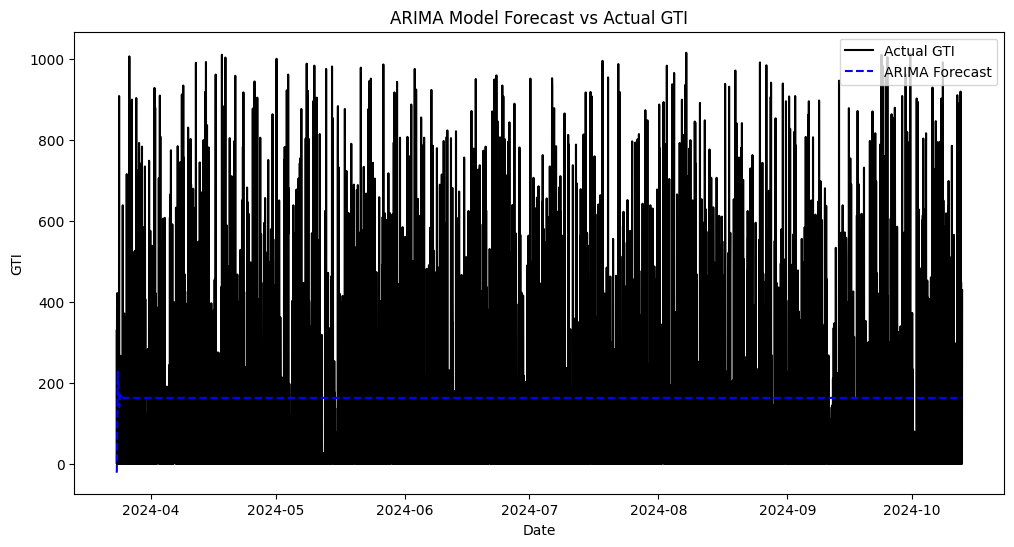

ARIMA Forecast for the next 24 hours: 2024-03-23 20:00:00+00:00    -21.755428
2024-03-23 21:00:00+00:00    -15.794921
2024-03-23 22:00:00+00:00     25.691557
2024-03-23 23:00:00+00:00     56.636559
2024-03-24 00:00:00+00:00    117.924093
2024-03-24 01:00:00+00:00    165.396029
2024-03-24 02:00:00+00:00    204.434202
2024-03-24 03:00:00+00:00    224.385920
2024-03-24 04:00:00+00:00    228.019326
2024-03-24 05:00:00+00:00    220.432399
2024-03-24 06:00:00+00:00    204.789524
2024-03-24 07:00:00+00:00    186.669491
2024-03-24 08:00:00+00:00    168.157377
2024-03-24 09:00:00+00:00    153.569020
2024-03-24 10:00:00+00:00    144.173954
2024-03-24 11:00:00+00:00    140.474918
2024-03-24 12:00:00+00:00    141.614183
2024-03-24 13:00:00+00:00    146.110700
2024-03-24 14:00:00+00:00    152.417899
2024-03-24 15:00:00+00:00    158.982572
2024-03-24 16:00:00+00:00    164.671162
2024-03-24 17:00:00+00:00    168.679526
2024-03-24 18:00:00+00:00    170.741670
2024-03-24 19:00:00+00:00    170.982838
Fr

In [ ]:
# ARIMA Model - Fit the ARIMA model on training data
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA Model
arima_model = ARIMA(train, order=(8, 1, 0))  # You can adjust the (p,d,q) order based on model tuning
arima_result = arima_model.fit()

# ARIMA Prediction (forecasting)
forecast = arima_result.forecast(steps=len(test))

# Evaluate ARIMA Model - Calculate MAE, RMSE, and R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_arima(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

arima_mae, arima_rmse, arima_r2 = evaluate_arima(y_test, forecast)
print(f"ARIMA - MAE: {arima_mae}, RMSE: {arima_rmse}, R2: {arima_r2}")

# Plotting ARIMA Results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label="Actual GTI", color='black')
plt.plot(test.index, forecast, label="ARIMA Forecast", linestyle="--", color='blue')
plt.legend()
plt.title("ARIMA Model Forecast vs Actual GTI")
plt.xlabel("Date")
plt.ylabel("GTI")
plt.show()


# Forecast the next 24 hours using ARIMA
arima_forecast_24hrs = arima_result.forecast(steps=24)

# Print the forecast for the next 24 hours
print(f"ARIMA Forecast for the next 24 hours: {arima_forecast_24hrs}")


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Fit the ARIMA model
arima_model = ARIMA(y_train, order=(8, 1, 0))  # Replace (p, d, q) with actual parameters
arima_result = arima_model.fit()

# Make predictions on the training set
arima_train_predictions = arima_result.fittedvalues

# Evaluate the ARIMA model on the training set
arima_mae_train = mean_absolute_error(y_train, arima_train_predictions)
arima_rmse_train = np.sqrt(mean_squared_error(y_train, arima_train_predictions))
arima_r2_train = r2_score(y_train, arima_train_predictions)

# Make predictions on the test set
y_test_forecast = arima_result.forecast(steps=len(y_test))

# Evaluate the ARIMA model on the test set
arima_mae_test = mean_absolute_error(y_test, y_test_forecast)
arima_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_forecast))
arima_r2_test = r2_score(y_test, y_test_forecast)

# Print evaluation metrics
print("ARIMA - Training Set Evaluation:")
print(f"MAE: {arima_mae_train}, RMSE: {arima_rmse_train}, R²: {arima_r2_train}")

print("ARIMA - Test Set Evaluation:")
print(f"MAE: {arima_mae_test}, RMSE: {arima_rmse_test}, R²: {arima_r2_test}")



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

ARIMA - Training Set Evaluation:
MAE: 183.11014505954478, RMSE: 245.42995990924922, R²: -0.11005690246200905
ARIMA - Test Set Evaluation:
MAE: 251.0900685805443, RMSE: 274.8686717948492, R²: -0.31897001405184566


Random Forest - MAE: 6.96602567240944, RMSE: 19.3082422882325, R2: 0.9934916647714676


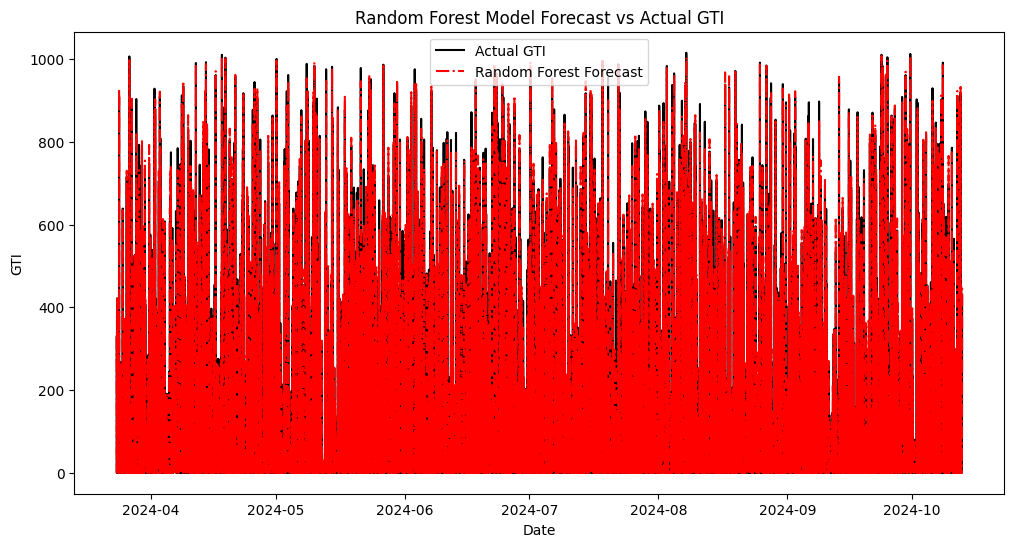

Random Forest Forecast for the next 24 hours: [448.73972156778905, 292.9273123348951, 9.413793555168825, 48.15086408237394, 0.5192226642356002, 449.92628214788664, 84.42116698264613, 82.07632849037614, 216.58011561771, 10.573606526470968, 46.42218694588006, 2.1227824856647617, 451.32596145464987, 99.9026284428603, 80.08611167695524, 180.2750077363799, 17.11171865846226, 44.10654887290822, 2.8229360234875145, 458.9134326359264, 112.66386939527276, 80.57191754596462, 163.17488631607887, 19.548777615583877]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Log-transform the target variable
y_train_log = np.log1p(y_train)  # Log(1 + y) transformation

# Define the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Fit the model on the transformed target variable
rf_model.fit(X_train, y_train_log)

# 3. Hyperparameter Tuning (Grid Search)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_search.fit(X_train, y_train_log)
best_rf = grid_search.best_estimator_

# 4. Predict on test data (inverse transform the predictions)
rf_forecast_log = best_rf.predict(X_test)
rf_forecast = np.expm1(rf_forecast_log)  # Inverse transformation: exp(y) - 1

# 5. Evaluate the Random Forest Model
rf_mae = mean_absolute_error(y_test, rf_forecast)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_forecast))
rf_r2 = r2_score(y_test, rf_forecast)

print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}, R2: {rf_r2}")

# 6. Plot Random Forest Results
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label="Actual GTI", color='black')
plt.plot(test.index, rf_forecast, label="Random Forest Forecast", linestyle="-.", color='red')
plt.legend()
plt.title("Random Forest Model Forecast vs Actual GTI")
plt.xlabel("Date")
plt.ylabel("GTI")
plt.show()

# 7. Forecast for the next 24 hours
# Get the last known feature set
last_known_features = pd.DataFrame([X_test.iloc[-1]], columns=X_train.columns)

# Initialize the forecast list
rf_forecast_24hrs = []

# Create a copy of the last known feature set for updating
for i in range(24):  # For 24 hours forecast
    # Predict the next hour (log scale)
    next_hour_log = best_rf.predict(last_known_features)
    next_hour = np.expm1(next_hour_log[0])  # Inverse transformation to original scale

    # Append the result to the forecast
    rf_forecast_24hrs.append(next_hour)

    # Update features for the next hour prediction
    # Example: Replace a relevant feature with the predicted value
    last_known_features = last_known_features.shift(-1, axis=1)  # Shift old features
    last_known_features.iloc[0, -1] = next_hour  # Insert the new prediction

    # Optionally, add time-based features (e.g., increment hour of day if present)

# Print the forecast for the next 24 hours
print(f"Random Forest Forecast for the next 24 hours: {rf_forecast_24hrs}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'X' and 'y' are your feature and target variables respectively
from sklearn.model_selection import train_test_split


# Replace these placeholders with your actual feature columns and target variable
# Example:
X = data[['air_temp', 'dhi', 'dni', 'cloud_opacity', 'relative_humidity', 'albedo', 'surface_pressure', 'zenith']]
y = data['gti']  # Assuming 'gti' is your target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the training set
rf_train_predictions = rf_model.predict(X_train)

# Evaluate the Random Forest model on the training set
rf_mae_train = mean_absolute_error(y_train, rf_train_predictions)
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_train_predictions))
rf_r2_train = r2_score(y_train, rf_train_predictions)

# Make predictions on the test set
rf_test_predictions = rf_model.predict(X_test)

# Evaluate the Random Forest model on the test set
rf_mae_test = mean_absolute_error(y_test, rf_test_predictions)
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_test_predictions))
rf_r2_test = r2_score(y_test, rf_test_predictions)

# Print evaluation metrics
print("Random Forest - Training Set Evaluation:")
print(f"MAE: {rf_mae_train}, RMSE: {rf_rmse_train}, R²: {rf_r2_train}")

print("Random Forest - Test Set Evaluation:")
print(f"MAE: {rf_mae_test}, RMSE: {rf_rmse_test}, R²: {rf_r2_test}")

Random Forest - Training Set Evaluation:
MAE: 4.951227041948362, RMSE: 13.690679940090547, R²: 0.996545858503904
Random Forest - Test Set Evaluation:
MAE: 7.486523373265726, RMSE: 20.463880167899465, R²: 0.9926892757624088


XGBoost - Test Set Evaluation:
MAE: 7.191110610961914, RMSE: 18.433539530938486, R²: 0.9940679669380188


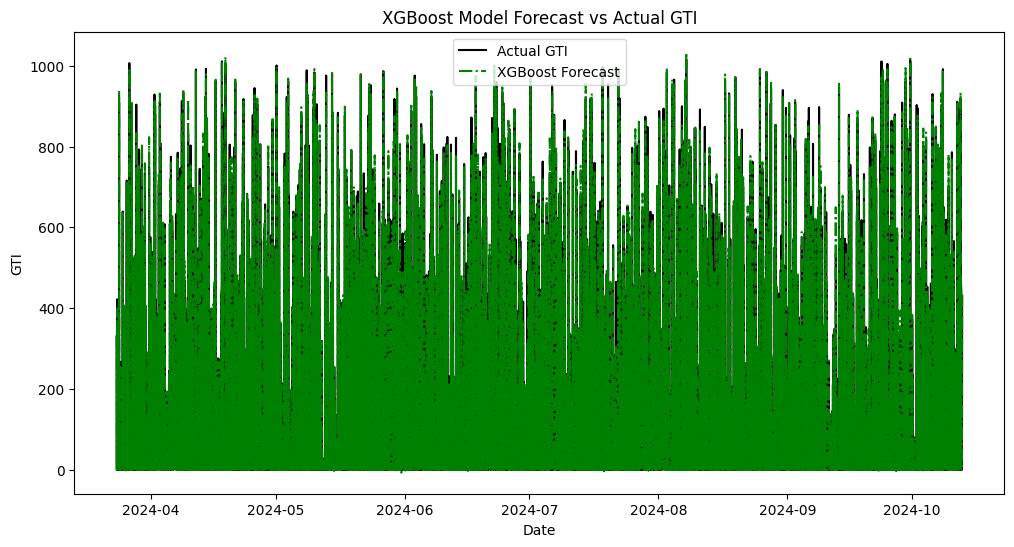

XGBoost Forecast for the next 24 hours: [434.42307, 450.24033, 10.214875, 21.969683, 923.6675, 478.80893, 99.79203, 288.06912, 438.652, -3.1819248, 878.1997, 385.13705, 516.5347, 131.01984, 270.10446, 410.51587, 568.6675, 328.43997, 412.19928, 508.4117, 142.69162, 272.52997, 446.73944, 272.2328]


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Create and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # Use reg:squarederror for regression
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the XGBoost model
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)


# Print evaluation metrics
print(f"XGBoost - Test Set Evaluation:")
print(f"MAE: {xgb_mae}, RMSE: {xgb_rmse}, R²: {xgb_r2}")


plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label="Actual GTI", color='black')
plt.plot(test.index, xgb_predictions, label="XGBoost Forecast", linestyle="-.", color='green')  # Use a distinct color
plt.legend()
plt.title("XGBoost Model Forecast vs Actual GTI")
plt.xlabel("Date")
plt.ylabel("GTI")
plt.show()

# Forecast for the next 24 hours using XGBoost
# Get the last known feature set
last_known_features_xgb = pd.DataFrame([X_test.iloc[-1]], columns=X_train.columns)

xgb_forecast_24hrs = []

for _ in range(24):
    next_hour = xgb_model.predict(last_known_features_xgb)[0]
    xgb_forecast_24hrs.append(next_hour)

    # Update the features for the next prediction (crucial for time series)
    last_known_features_xgb = last_known_features_xgb.shift(-1, axis=1)
    last_known_features_xgb.iloc[0, -1] = next_hour # Update with last prediction

print(f"XGBoost Forecast for the next 24 hours: {xgb_forecast_24hrs}")


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the training set
xgb_train_predictions = xgb_model.predict(X_train)

# Evaluate the XGBoost model on the training set
xgb_mae_train = mean_absolute_error(y_train, xgb_train_predictions)
xgb_rmse_train = np.sqrt(mean_squared_error(y_train, xgb_train_predictions))
xgb_r2_train = r2_score(y_train, xgb_train_predictions)

# Make predictions on the test set
xgb_test_predictions = xgb_model.predict(X_test)

# Evaluate the XGBoost model on the test set
xgb_mae_test = mean_absolute_error(y_test, xgb_test_predictions)
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_test_predictions))
xgb_r2_test = r2_score(y_test, xgb_test_predictions)

# Print evaluation metrics
print("XGBoost - Training Set Evaluation:")
print(f"MAE: {xgb_mae_train}, RMSE: {xgb_rmse_train}, R²: {xgb_r2_train}")

print("XGBoost - Test Set Evaluation:")
print(f"MAE: {xgb_mae_test}, RMSE: {xgb_rmse_test}, R²: {xgb_r2_test}")




XGBoost - Training Set Evaluation:
MAE: 6.041027545928955, RMSE: 15.171679384520347, R²: 0.9957581162452698
XGBoost - Test Set Evaluation:
MAE: 7.376368999481201, RMSE: 19.145895320334002, R²: 0.9936006665229797


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scale features for LSTM (LSTM requires data to be normalized)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM - LSTM expects input in 3D format [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM Model
def train_lstm_model(X_train_lstm, y_train):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train, epochs=100, batch_size=45, verbose=0)
    return model

# Train the LSTM Model
lstm_model = train_lstm_model(X_train_lstm, y_train)

# LSTM Prediction (forecasting)
lstm_forecast = lstm_model.predict(X_test_lstm).flatten()

# Evaluate LSTM Model
lstm_mae = mean_absolute_error(y_test, lstm_forecast)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_forecast))
lstm_r2 = r2_score(y_test, lstm_forecast)

print(f"LSTM - MAE: {lstm_mae}, RMSE: {lstm_rmse}, R2: {lstm_r2}")

#  LSTM 24-hour forecast
LSTM_forecast_24hrs = []
last_known_features_lstm = X_test_scaled[-1].reshape(1, 1, -1)

for _ in range(24):
    next_hour_scaled = lstm_model.predict(last_known_features_lstm)

    # Reshape to (1, num_features) before inverse_transform
    # Reshape to match the original number of features (9 in this case)
    next_hour_scaled_reshaped = next_hour_scaled.reshape(1, -1)

    # Pad with zeros to match the expected number of features if necessary
    next_hour_scaled_padded = np.pad(next_hour_scaled_reshaped, ((0, 0), (0, X_train_scaled.shape[1] - next_hour_scaled_reshaped.shape[1])), 'constant', constant_values=0)

    next_hour = scaler.inverse_transform(next_hour_scaled_padded)[:, 0]  # Assuming GHI is at index 0

    LSTM_forecast_24hrs.append(next_hour[0])

    # Update last_known_features_lstm to include all features for the next prediction
    last_known_features_lstm = next_hour_scaled_padded.reshape(1, 1, X_train_scaled.shape[1])  # Reshape back to 3D

# Print the forecast for the next 24 hours
print(f"LSTM for the next 24 hours: {LSTM_forecast_24hrs}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM - MAE: 11.586105346679688, RMSE: 25.192480460989618, R2: 0.9889203310012817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Scale features for LSTM (LSTM requires data to be normalized)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM - LSTM expects input in 3D format [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM Model
def train_lstm_model(X_train_lstm, y_train):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train, epochs=100, batch_size=45, verbose=0)
    return model

# Train the LSTM Model
lstm_model = train_lstm_model(X_train_lstm, y_train)

# Make predictions on the training set
lstm_train_forecast = lstm_model.predict(X_train_lstm).flatten()

# Evaluate the LSTM Model on the training set
lstm_mae_train = mean_absolute_error(y_train, lstm_train_forecast)
lstm_rmse_train = np.sqrt(mean_squared_error(y_train, lstm_train_forecast))
lstm_r2_train = r2_score(y_train, lstm_train_forecast)

# Make predictions on the test set
lstm_test_forecast = lstm_model.predict(X_test_lstm).flatten()

# Evaluate the LSTM Model on the test set
lstm_mae_test = mean_absolute_error(y_test, lstm_test_forecast)
lstm_rmse_test = np.sqrt(mean_squared_error(y_test, lstm_test_forecast))
lstm_r2_test = r2_score(y_test, lstm_test_forecast)

# Print evaluation metrics
print("LSTM - Training Set Evaluation:")
print(f"MAE: {lstm_mae_train}, RMSE: {lstm_rmse_train}, R²: {lstm_r2_train}")

print("LSTM - Test Set Evaluation:")
print(f"MAE: {lstm_mae_test}, RMSE: {lstm_rmse_test}, R²: {lstm_r2_test}")




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LSTM - Training Set Evaluation:
MAE: 11.63757610321045, RMSE: 25.422297553341338, R²: 0.9880897998809814
LSTM - Test Set Evaluation:
MAE: 11.840323448181152, RMSE: 25.69242986072819, R²: 0.9884762167930603


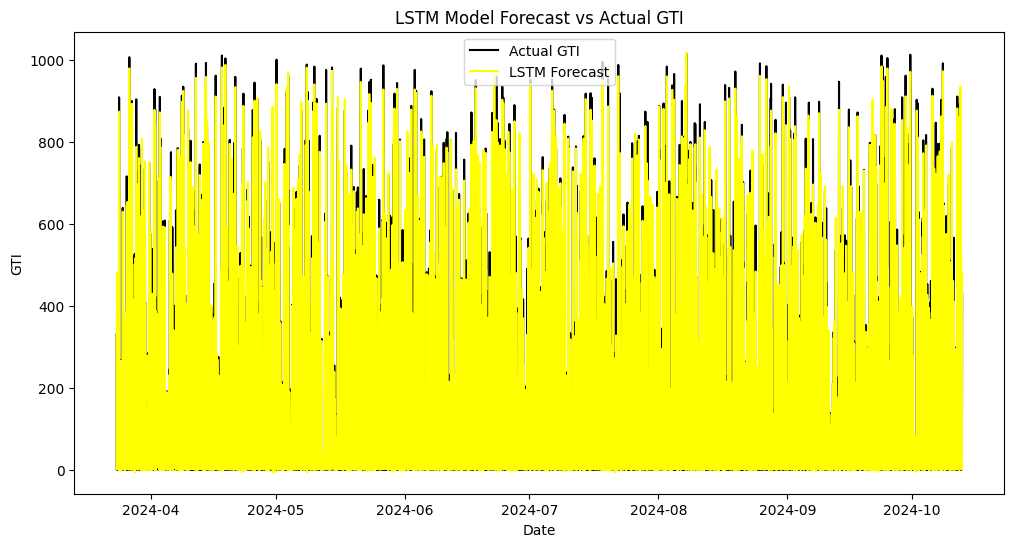

In [ ]:
# prompt: create code to visualise LSTM forcast visualisation

import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Plotting LSTM Results
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label="Actual GTI", color='black')
plt.plot(test.index, lstm_forecast, label="LSTM Forecast", linestyle="-", color='yellow') # Use a distinct color
plt.legend()
plt.title("LSTM Model Forecast vs Actual GTI")
plt.xlabel("Date")
plt.ylabel("GTI")
plt.show()


In [ ]:
# prompt: create a code to tabulate the 24hrs forcast above

import pandas as pd

# Assuming arima_forecast_24hrs, rf_forecast_24hrs, and lstm_forecast_24hrs are already calculated

# Create a DataFrame for better visualization
forecast_df = pd.DataFrame({
    'Hour': range(1, 25),
    'ARIMA': arima_forecast_24hrs,
    'Random Forest': rf_forecast_24hrs,
    'LSTM': LSTM_forecast_24hrs,
    'XGBoost':xgb_forecast_24hrs
})

# Display the table
forecast_df



,Hour,ARIMA,Random Forest,LSTM,XGBoost
2024-03-23 20:00:00+00:00,1,-21.755428,448.739722,2.125279e+04,434.423065
2024-03-23 21:00:00+00:00,2,-15.794921,292.927312,2.369989e+05,450.240326
2024-03-23 22:00:00+00:00,3,25.691557,9.413794,2.629114e+06,10.214875
2024-03-23 23:00:00+00:00,4,56.636559,48.150864,2.915201e+07,21.969683
2024-03-24 00:00:00+00:00,5,117.924093,0.519223,3.232282e+08,923.667480
2024-03-24 01:00:00+00:00,6,165.396029,449.926282,3.583838e+09,478.808929
2024-03-24 02:00:00+00:00,7,204.434202,84.421167,3.973630e+10,99.792030
2024-03-24 03:00:00+00:00,8,224.385920,82.076328,4.405816e+11,288.069122
2024-03-24 04:00:00+00:00,9,228.019326,216.580116,4.885010e+12,438.652008
2024-03-24 05:00:00+00:00,10,220.432399,10.573607,5.416321e+13,-3.181925


In [ ]:
#create code to calculate residual for each model

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf

# Assuming 'data' DataFrame is already defined and loaded
# Feature Selection
selected_features = ['air_temp','dhi','dni','cloud_opacity','relative_humidity','albedo','surface_pressure','zenith']  # Exclude GHI if it's the target
target_variable = "gti"  # Use GTI as the target variable

X = data[selected_features]
y = data[target_variable]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split into train and test sets (80:20 split)
train_size = int(len(data) * 0.8)
train, test = data[target_variable][:train_size], data[target_variable][train_size:]

# Function to calculate residuals
def calculate_residuals(y_true, y_pred):
  return np.array(y_true) - np.array(y_pred)

# ARIMA Model
arima_model = ARIMA(train, order=(8, 1, 0))
arima_result = arima_model.fit()
forecast = arima_result.forecast(steps=len(test))

# Calculate ARIMA residuals
arima_residuals = calculate_residuals(y_test, forecast)

# Evaluate ARIMA on the training set
arima_model = ARIMA(y_train, order=(8, 1, 0))
arima_result = arima_model.fit()
arima_train_predictions = arima_result.fittedvalues
arima_train_residuals=calculate_residuals(y_train,arima_train_predictions)

#Random Forest
y_train_log = np.log1p(y_train)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_search.fit(X_train, y_train_log)
best_rf = grid_search.best_estimator_
rf_forecast_log = best_rf.predict(X_test)
rf_forecast = np.expm1(rf_forecast_log)
# Calculate Random Forest residuals
rf_residuals = calculate_residuals(y_test, rf_forecast)

#Random Forest on the train set
rf_model.fit(X_train, y_train)
rf_train_predictions = rf_model.predict(X_train)
rf_train_residuals = calculate_residuals(y_train, rf_train_predictions)

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Calculate XGBoost residuals
xgb_residuals = calculate_residuals(y_test, xgb_predictions)

#XGBoost on train set
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_train_predictions = xgb_model.predict(X_train)
xgb_train_residuals = calculate_residuals(y_train, xgb_train_predictions)


# LSTM Model
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

def train_lstm_model(X_train_lstm, y_train):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train, epochs=100, batch_size=45, verbose=0)
    return model

lstm_model = train_lstm_model(X_train_lstm, y_train)
lstm_forecast = lstm_model.predict(X_test_lstm).flatten()

# Calculate LSTM residuals
lstm_residuals = calculate_residuals(y_test, lstm_forecast)

#LSTM training Set
lstm_train_forecast = lstm_model.predict(X_train_lstm).flatten()
lstm_train_residuals = calculate_residuals(y_train, lstm_train_forecast)

# Print or further analyze the residuals
print("ARIMA Residuals (Test):", arima_residuals)
print("Random Forest Residuals (Test):", rf_residuals)
print("XGBoost Residuals (Test):", xgb_residuals)
print("LSTM Residuals (Test):", lstm_residuals)

print("ARIMA Residuals (Train):", arima_train_residuals)
print("Random Forest Residuals (Train):", rf_train_residuals)
print("XGBoost Residuals (Train):", xgb_train_residuals)
print("LSTM Residuals (Train):", lstm_train_residuals)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monot

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ARIMA Residuals (Test): [ 350.75542763   15.79492054  358.30844276 ... -163.14209019 -163.14209019
  265.85790981]
Random Forest Residuals (Test): [  0.22986426   0.         -36.68423671 ...   0.           0.
 -19.73972157]
XGBoost Residuals (Test): [ -4.19641113  -0.15774941 -15.88339233 ...   0.12477111   0.37294927
  -5.42306519]
LSTM Residuals (Test): [ -1.85324097  -0.81968212 -94.46289062 ...  -0.92209625   0.83670425
 -58.74526978]
ARIMA Residuals (Train): [  11.          -10.46139093  335.63582198 ... -381.83215512 -365.95649102
   57.03482199]
Random Forest Residuals (Train): [ 0.08  0.   -0.48 ...  0.    0.    6.45]
XGBoost Residuals (Train): [-0.25080585  0.24377489 -4.08688354 ... -0.29565856 -0.12743315
 14.03015137]
LSTM Residuals (Train): [-2.15036964  0.5816679  21.69726562 ... -0.62401104  0.30169296
  1.82312012]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monot

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
610/610 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


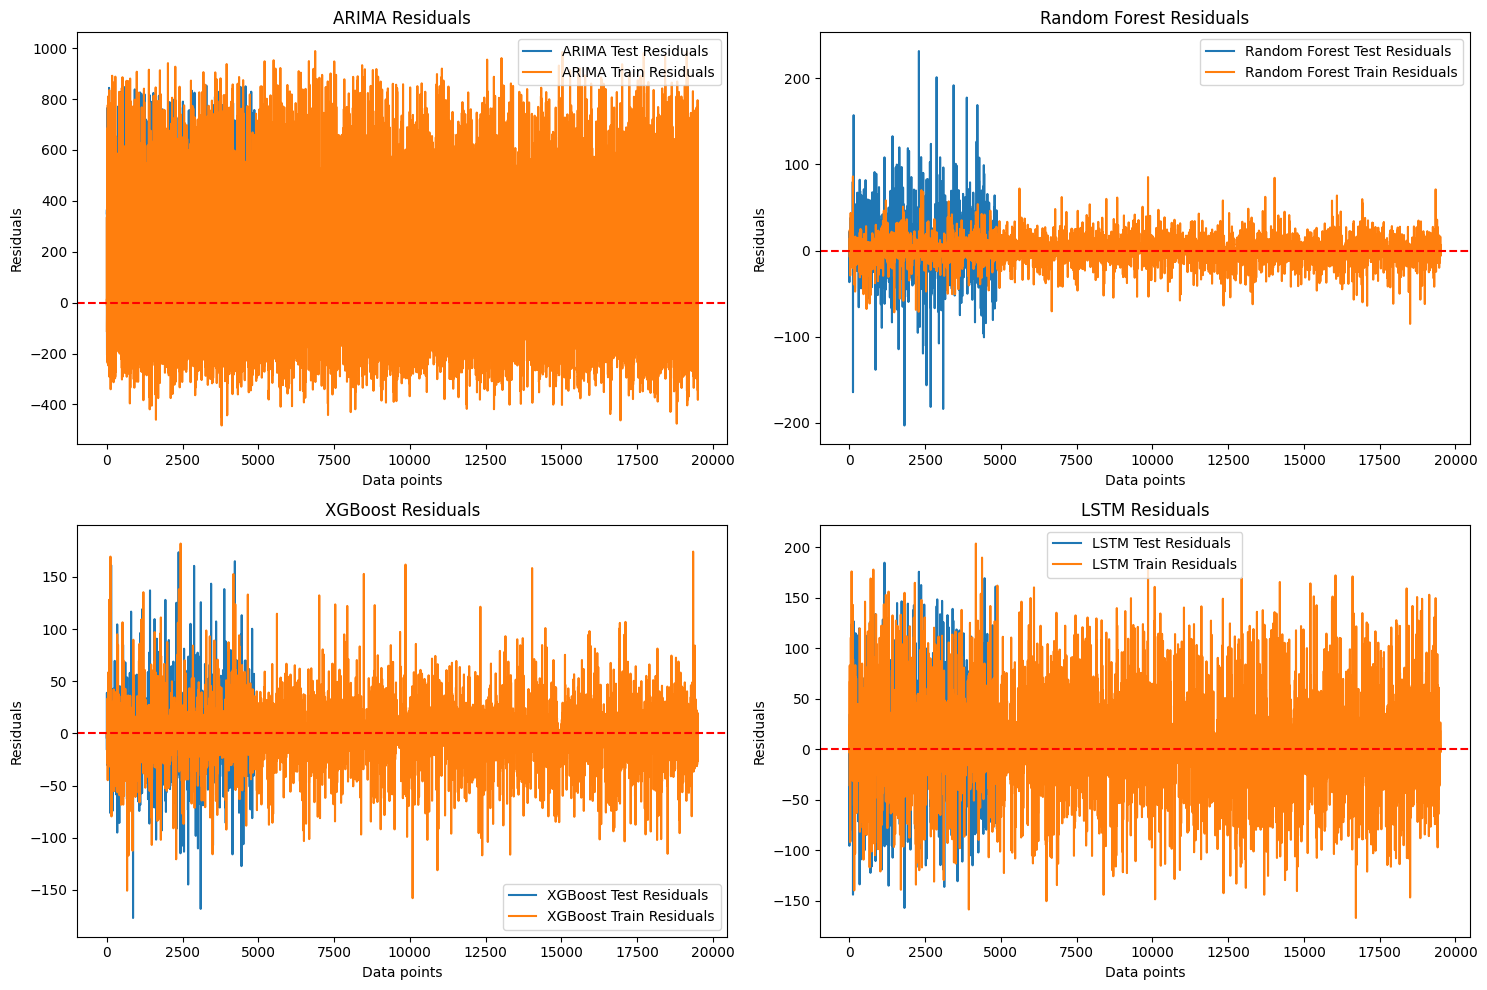

In [ ]:
# prompt: create code to plot reisdual for each model

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf

# Assuming 'data' DataFrame is already defined and loaded
# Feature Selection
selected_features = ['air_temp','dhi','dni','cloud_opacity','relative_humidity','albedo','surface_pressure','zenith']  # Exclude GHI if it's the target
target_variable = "gti"  # Use GTI as the target variable

X = data[selected_features]
y = data[target_variable]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split into train and test sets (80:20 split)
train_size = int(len(data) * 0.8)
train, test = data[target_variable][:train_size], data[target_variable][train_size:]

# Function to calculate residuals
def calculate_residuals(y_true, y_pred):
  return np.array(y_true) - np.array(y_pred)

# ARIMA Model
arima_model = ARIMA(train, order=(8, 1, 0))
arima_result = arima_model.fit()
forecast = arima_result.forecast(steps=len(test))

# Calculate ARIMA residuals
arima_residuals = calculate_residuals(y_test, forecast)

# Evaluate ARIMA on the training set
arima_model = ARIMA(y_train, order=(8, 1, 0))
arima_result = arima_model.fit()
arima_train_predictions = arima_result.fittedvalues
arima_train_residuals=calculate_residuals(y_train,arima_train_predictions)

#Random Forest
y_train_log = np.log1p(y_train)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_search.fit(X_train, y_train_log)
best_rf = grid_search.best_estimator_
rf_forecast_log = best_rf.predict(X_test)
rf_forecast = np.expm1(rf_forecast_log)
# Calculate Random Forest residuals
rf_residuals = calculate_residuals(y_test, rf_forecast)

#Random Forest on the train set
rf_model.fit(X_train, y_train)
rf_train_predictions = rf_model.predict(X_train)
rf_train_residuals = calculate_residuals(y_train, rf_train_predictions)

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Calculate XGBoost residuals
xgb_residuals = calculate_residuals(y_test, xgb_predictions)

#XGBoost on train set
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_train_predictions = xgb_model.predict(X_train)
xgb_train_residuals = calculate_residuals(y_train, xgb_train_predictions)


# LSTM Model
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

def train_lstm_model(X_train_lstm, y_train):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train, epochs=100, batch_size=45, verbose=0)
    return model

lstm_model = train_lstm_model(X_train_lstm, y_train)
lstm_forecast = lstm_model.predict(X_test_lstm).flatten()

# Calculate LSTM residuals
lstm_residuals = calculate_residuals(y_test, lstm_forecast)

#LSTM training Set
lstm_train_forecast = lstm_model.predict(X_train_lstm).flatten()
lstm_train_residuals = calculate_residuals(y_train, lstm_train_forecast)


# Plotting Residuals
plt.figure(figsize=(15, 10))

# ARIMA Residuals
plt.subplot(2, 2, 1)
plt.plot(arima_residuals, label='ARIMA Test Residuals')
plt.plot(arima_train_residuals, label='ARIMA Train Residuals')
plt.title('ARIMA Residuals')
plt.legend()
plt.xlabel("Data points")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')

# Random Forest Residuals
plt.subplot(2, 2, 2)
plt.plot(rf_residuals, label='Random Forest Test Residuals')
plt.plot(rf_train_residuals, label='Random Forest Train Residuals')
plt.title('Random Forest Residuals')
plt.legend()
plt.xlabel("Data points")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')

# XGBoost Residuals
plt.subplot(2, 2, 3)
plt.plot(xgb_residuals, label='XGBoost Test Residuals')
plt.plot(xgb_train_residuals, label='XGBoost Train Residuals')
plt.title('XGBoost Residuals')
plt.legend()
plt.xlabel("Data points")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')

# LSTM Residuals
plt.subplot(2, 2, 4)
plt.plot(lstm_residuals, label='LSTM Test Residuals')
plt.plot(lstm_train_residuals, label='LSTM Train Residuals')
plt.title('LSTM Residuals')
plt.legend()
plt.xlabel("Data points")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
# prompt: create a code to generate  Feature importance from Random Forest

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust n_estimators if needed
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for easier viewing
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
feature_importances_df

,Feature,Importance
2,dni,0.656262
7,zenith,0.167396
1,dhi,0.162555
5,albedo,0.004198
0,air_temp,0.004085
3,cloud_opacity,0.002860
4,relative_humidity,0.001354
6,surface_pressure,0.001289


In [ ]:
# prompt: create a code to generate  Feature importance from XGBoost

import xgboost as xgb

# Assuming xgb_model is your trained XGBoost model
# and X_train is your training features DataFrame

# Get feature importances
xgb_importances = xgb_model.feature_importances_

# Create a DataFrame for easier viewing
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
feature_importances_df

,Feature,Importance
2,dni,0.516195
7,zenith,0.278951
1,dhi,0.176343
5,albedo,0.010682
0,air_temp,0.007696
3,cloud_opacity,0.006687
6,surface_pressure,0.001758
4,relative_humidity,0.001686
